# PRODUCT RECOGNITION ON STORE SHELVES

### Manuel Gabrielli - manuel.gabrielli@studio.unibo.it


---


## Overall Task:
Develop a computer vision system that, given a reference image for each product, is able to identify boxes of cereals of different brands from one picture of a store shelf. For each type of product displayed in the shelf the system should report:
1. Number of instances.
2. Dimension of each instance (width and height of the bounding box that enclose them in pixel).<br>
<img src="imageAssignment1.png" width="500"><br>
3. Position in the image reference system of each instance (center of the bounding box that enclose them in pixel).
For example, as output of the above image the system should print: <br>
<img src="imageAssignment2.png" width="600">


## Step A - Multiple Product Detection

- Test on scene image: {e1.png, e2.png, e3.png, e4.png, e5.png}
- Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 25.jpg, 26.jpg}

Develop an object detection system to identify single instance of products given: one reference image for
each item and a scene image. 

The system should be able to correctly identify all the product in the shelves
image.

In [28]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [29]:
def get_model(i, printDetails):
    if i == 0:
        if(printDetails):
            print("Model " + str(model_index[i]) +": Nesquik Cioccomilk")
        return "Nesquik"
    elif i == 1:
        if(printDetails):
            print("Model " + str(model_index[i]) +": Blue ChocoKrave")
        return "CK Blue"
    elif i == 11:
        if(printDetails):
            print("Model " + str(model_index[i]) +": Orange ChocoKrave")
        return "CK Orange"
    elif i == 19:
        if(printDetails):
            print("Model " + str(model_index[i]) +": Country Crisp")
        return "Country Crisp"
    elif i == 24:
        if(printDetails):
            print("Model " + str(model_index[i]) +": Fitness")
        return "Fitness"
    elif i == 25:
        if(printDetails):
            print("Model " + str(model_index[i]) +": Coco Pops")
        return "Coco Pops"
    elif i == 26:
        if(printDetails):
            print("Model " + str(model_index[i]) +": Nesquik Duo")
        return "Nesquik Duo"

In [30]:
def readImages():
    #open and conversion to original colours
    images = {}
    for i in range(num_models):
        img = cv2.imread(models_path+str(model_index[i])+models_estenstion);
        images[i] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
    
    #open and conversion to original colours
    scenes = {}
    for i in range(num_scenes):
        img = cv2.imread(scene_path+scenes_names[i]+scenes_estenstion);
        scenes[i] = cv2.cvtColor(img,cv2.COLOR_BGR2RGB);
        
    return images, scenes

In [31]:
def getKeypoints(image):
    # find the keypoints and descriptors with SIFT
    kp_image = sift.detect(image)
    
    # Describing keypoints for image
    kp_image, des_image = sift.compute(image, kp_image)
    
    return kp_image, des_image

In [32]:
# the centroid or geometric center of a plane figure is the arithmetic mean position of all the points in the shape.
#calculated by the sum of the x coord divided by the number and the sum of y coord dividend by the number
def getCentroid(vertices):
    sum_coord = [0,0]
    for i in range(len(vertices)):
        sum_coord = sum_coord + vertices[i][0]
    return (int(sum_coord[0]/len(vertices)), int(sum_coord[1]/len(vertices)))

In [33]:
def printResults(occurences): 
    for o in occurences.keys():
        print("\nProduct {} - {} instance found:\n".format(o, len(occurences[o])))

        #[{'height': 438, 'width': 310, 'center': (162, 214)}]

        listOcc = occurences[o]

        for i in range(len(listOcc)):
            center = listOcc[i]["center"]
            height = listOcc[i]["height"]
            width = listOcc[i]["width"]
            print("\tInstance "+str(i+1)+": {position: ("+str(center[0])+","+str(center[1])+"), width: "+str(width)+"px, heigh: "+str(height)+"px}")


In [34]:
def getFeatureMatcher():
    # Defining index for approximate kdtree algorithm
    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    return flann

In [35]:
def searchTemplates(models, scene):
    # Describing keypoints for scene image
    kp_scene, des_scene = getKeypoints(scene)

    matches = {}
    
    for i in range(len(models)):
        # Matching and finding the 2 closest elements for each query descriptor.
        matches[i] = flann.knnMatch(des_models[i],des_scene,k=2)

    good = {}
    for i in range(len(models)):
        good[i] = []
        for m,n in matches[i]:
            if m.distance < 0.7*n.distance:
                good[i].append(m)


    per_check = []
    #loop over all the possible models
    for i in range(len(models)):

        if len(good[i])>MIN_MATCH_COUNT:

            # building the corrspondences arrays of good matches
            src_pts = np.float32([ kp_models[i][m.queryIdx].pt for m in good[i] ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good[i] ]).reshape(-1,1,2)
            # Using RANSAC to estimate a robust homography. 
            # It returns the homography M and a mask for the discarded points
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Mask of discarded point used in visualization
            matchesMask = mask.ravel().tolist()

            # Corners of the query image
            h,w = images[i].shape[0:2]
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            # Projecting the corners into the train image
            dst = cv2.perspectiveTransform(pts,M)

            #FACENDO IL CONTROLLO SUL COLORE DELL'AREA CAPISCONO QUALI SONO LE SCATOLE PRESENTI E QUALI NO

            #controlla che la scatola non sia troppo inclinata, e quindi storpiata
            if ((abs(dst[0,0][0]-dst[1,0][0])<30) and abs(dst[0,0][1]-dst[3,0][1])<30 
                and abs(dst[2,0][0]-dst[3,0][0])<30 and abs(dst[1,0][1]-dst[2,0][1])<30):

                #if dealing with chocokrave (correct model)
                if (model_index[i] == 1 or model_index[i]==11):
                    dst= np.int32(dst)+(0,30)

                #cambio le coordinate per non avere indici negativi o indici che eccedono la dimensione dell'immagine
                x_min=int((dst[0,0][0]+dst[1,0][0])/2)
                if(x_min<0):
                    x_min=0
                if(x_min>=scene.shape[1]): #se esce dalla figura perchè è maggiore della dimensione della scena lo metto a uno 
                    x_min=scene.shape[1]-1 #in meno rispetto alla dimensione della scena
                y_min=int((dst[0,0][1]+dst[3,0][1])/2)
                if(y_min<0):
                    y_min=0
                if(y_min>=scene.shape[0]):
                    y_min=scene.shape[0]-1
                x_max=int((dst[2,0][0]+dst[3,0][0])/2)
                if(x_max<0):
                    x_max=0
                if(x_max>=scene.shape[1]):
                    x_max=scene.shape[1]-1
                y_max=int((dst[1,0][1]+dst[2,0][1])/2)
                if(y_max<0):
                    y_max=0
                if(y_max>=scene.shape[0]):
                    y_max=scene.shape[0]-1

                #escludo il primo terzo
                #calcolo max_y(y2)-min_y(y1)/3 e sommo y_1 per traslarlo
                start_row = int(y_min+(y_max-y_min)/3)

                #control over the colour of a significant area
                area = scene[start_row:y_max, x_min:x_max]

                #se l'area selezionata non è vuota
                if(area.shape[0] != 0 and area.shape[1]!= 0):
                    average_area_row = np.average(area, axis=0)
                    average_area = np.average(average_area_row, axis=0).astype(int).tolist()

                    #print(accum_area, ref_colour[i])

                    color_first=abs(average_colors[i][0]-average_area[0])
                    color_second=abs(average_colors[i][1]-average_area[1])
                    color_third=abs(average_colors[i][2]-average_area[2])

                    #check on colour mean
                    #la differenza tra il colore primario ottenuto dell'area e quello del modello deve essere entro certi parametri
                    if(color_first<33 and color_second<33 and color_third <33 and  color_first+color_second+color_third<60):
                    #check on colour mean
                        
                        width = int(round(dst[2,0][0] - dst[0,0][0]))
                        height = int(round(dst[1,0][1] - dst[0,0][1]))
                        lower_width = int(round(dst[3,0][0] - dst[1,0][0]))
                        lower_height = int(round(dst[2,0][1] - dst[3,0][1]))
                        perimeter=width+lower_width+height+lower_height
                        per_check.append({"index":model_index[i],"perimeter":perimeter, "dst":dst})
        else:
            matchesMask = None
    return per_check

In [36]:
def drawResults(scene, per_check):
    
    current_index = -1
    occurences = {}
    
    for i in range(len(per_check)):
       
        dst = per_check[i]["dst"]
        model_ind = per_check[i]["index"]
        perimeter = per_check[i]["perimeter"]
        if(current_index != model_ind):
            current_index = model_ind
            occurences[current_index] = []
            
        text = get_model(model_ind, False)
        
        # Drawing the bounding box
        scene = cv2.polylines(scene,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_AA)

        (text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=3)[0]
        offset_1=(int(dst[1,0][0]), int(dst[1,0][1])+10)
        offset_2=(int(dst[2,0][0]), int(dst[1,0][1])-text_height-5)
        cv2.rectangle(scene,offset_1, offset_2, (0,255,0), cv2.FILLED)
        width = int(round(dst[2,0][0] - dst[0,0][0]))
        height = int(round(dst[1,0][1] - dst[0,0][1]))
        #centered position of the text wrt the rectangle
        org = (int(dst[1,0][0]+(width/2-text_width/2)), int(dst[1,0][1])) 
        cv2.putText(scene,text,org, font, font_scale,(0,0,0),3,cv2.LINE_AA)

        #get center of the box
        center = getCentroid(dst)

        occurences[current_index].append({"height": height, "width": width, "center": center})
      
    #stampo i risultati ottenuti
    printResults(occurences)
    
    #print scene image
    plt.figure(figsize=(20, 10))
    plt.imshow(scene);
    plt.show();

In [37]:
#MODEL IMAGES
model_index = {
    0: 0,
    1: 1,
    2: 11,
    3: 19,
    4: 24,
    5: 25,
    6: 26
}

models_estenstion = ".jpg"

models_path = "models/"

num_models = len(model_index);

#SCENES IMAGES
scenes_names = ["e1", "e2", "e3", "e4", "e5"]

scenes_estenstion = ".png"

scene_path = "scenes/"

num_scenes = len(scenes_names)

#MACRO VARIABLES
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale=1.0

# Checking if we found enough matching
MIN_MATCH_COUNT = 60



Product 0 - 1 instance found:

	Instance 1: {position: (162,214), width: 310px, heigh: 438px}

Product 11 - 1 instance found:

	Instance 1: {position: (442,197), width: 299px, heigh: 393px}


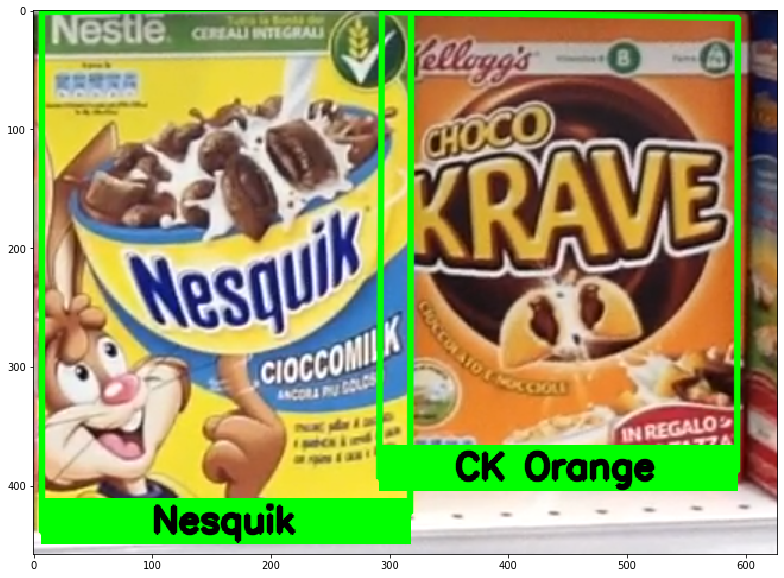


Product 0 - 1 instance found:

	Instance 1: {position: (574,164), width: 262px, heigh: 331px}

Product 24 - 1 instance found:

	Instance 1: {position: (167,219), width: 340px, heigh: 491px}

Product 25 - 1 instance found:

	Instance 1: {position: (878,232), width: 303px, heigh: 446px}

Product 26 - 1 instance found:

	Instance 1: {position: (538,218), width: 330px, heigh: 490px}


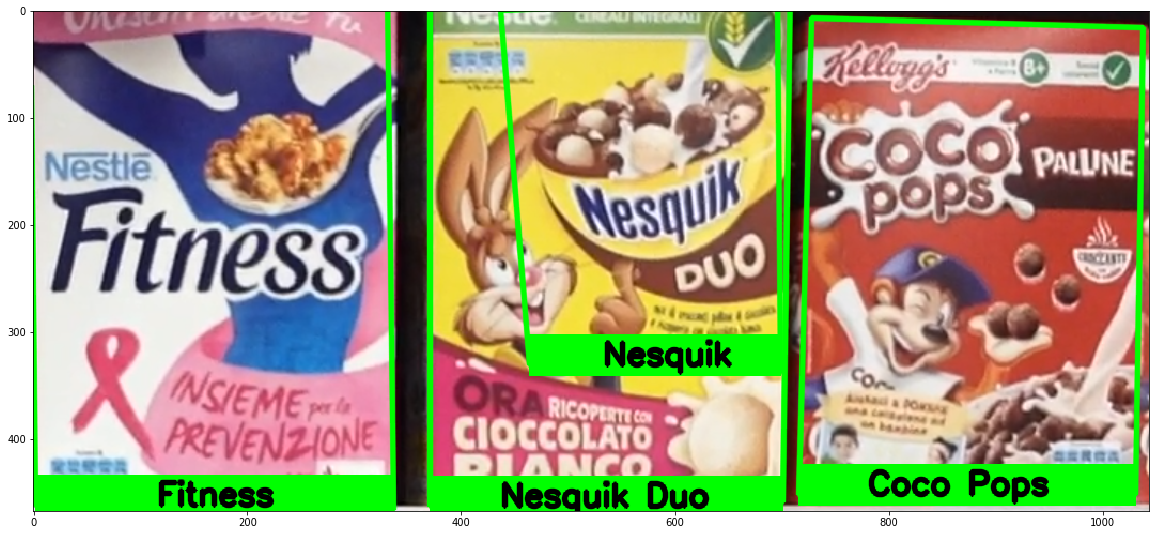


Product 0 - 1 instance found:

	Instance 1: {position: (170,236), width: 327px, heigh: 445px}

Product 11 - 1 instance found:

	Instance 1: {position: (474,216), width: 303px, heigh: 397px}


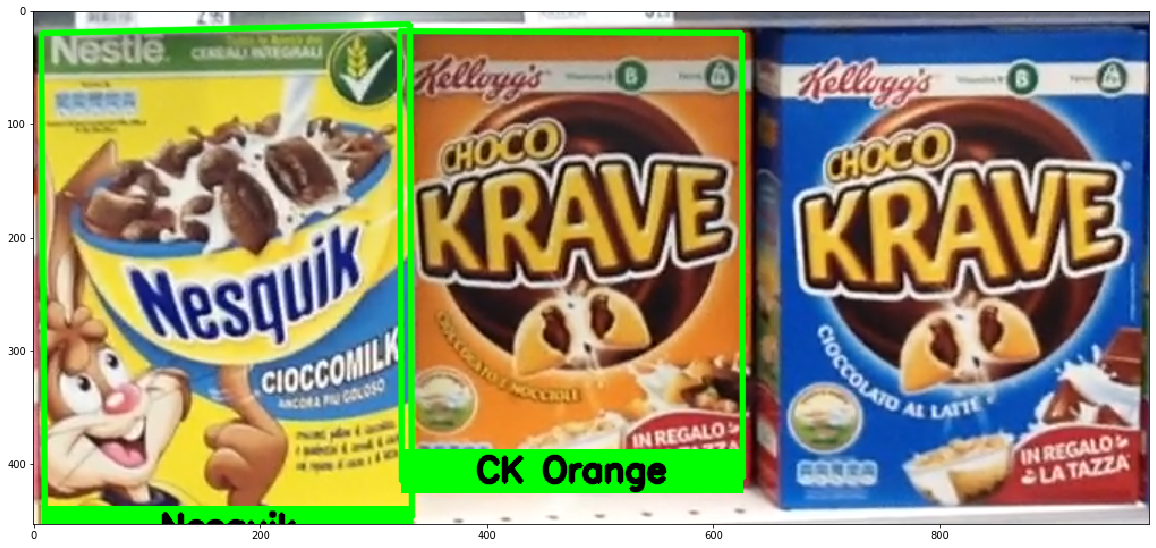


Product 0 - 1 instance found:

	Instance 1: {position: (158,739), width: 327px, heigh: 445px}

Product 11 - 1 instance found:

	Instance 1: {position: (462,719), width: 304px, heigh: 396px}

Product 25 - 1 instance found:

	Instance 1: {position: (555,208), width: 316px, heigh: 448px}

Product 26 - 1 instance found:

	Instance 1: {position: (205,195), width: 343px, heigh: 498px}


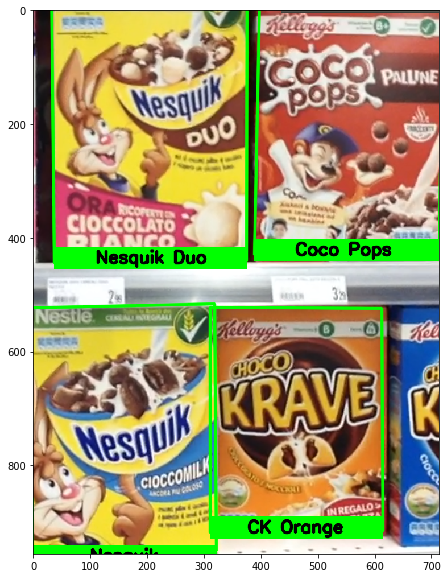


Product 19 - 1 instance found:

	Instance 1: {position: (504,190), width: 290px, heigh: 386px}

Product 25 - 1 instance found:

	Instance 1: {position: (161,227), width: 312px, heigh: 445px}


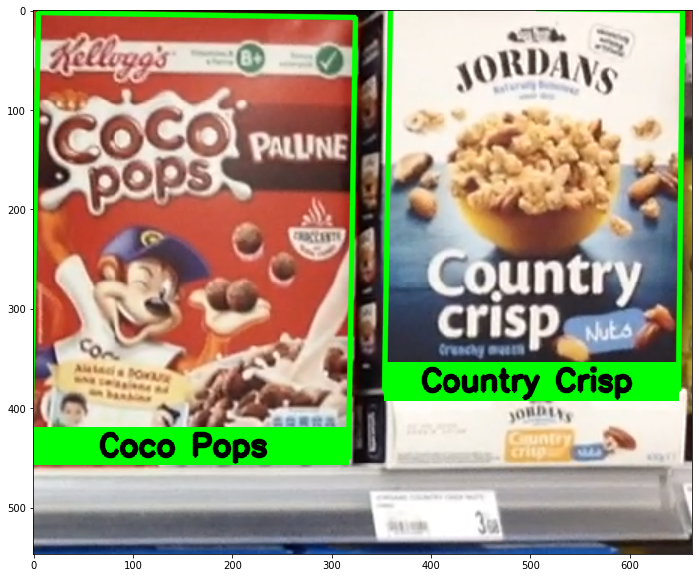

In [38]:
images, scenes = readImages()

#get avarage colour of each model image
average_colors = {}

for i in range(num_models):
    #non considero il primo terzo dell'immagine che molte volte contiene il logo della marca
    start_row = int(images[i].shape[0]/3)
    #seleziono la parte dell'imagine da considerare
    selected_image = images[i][start_row: images[i].shape[0], :]
    #faccio la media
    average_color_row = np.average(selected_image, axis=0)
    average_colors[i] = np.average(average_color_row, axis=0).astype(int).tolist()

# Initiate SIFT detector
sift = cv2.SIFT_create()
flann = getFeatureMatcher()

kp_models = {}
des_models = {}

for i in range(num_models):
    # Describing keypoints for model images
    kp_models[i], des_models[i] = getKeypoints(images[i])
    
for i in range(len(scenes)):
        #creo una copia della scena da modificare
        copy_scene = np.copy(scenes[i])
        per_check = searchTemplates(images, copy_scene)
        drawResults(copy_scene, per_check)